In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense, Conv2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from tensorflow.keras.callbacks import TensorBoard
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an iss

Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 602 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


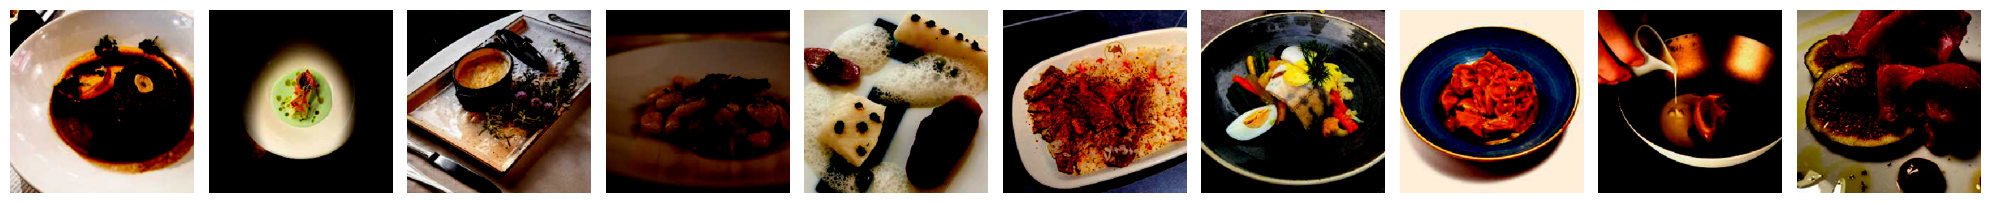

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [6]:
#Set up values
epochs = 30
input_shape=(299,299,3)
batch_size=16
classes=['On_a_budget', 'Moderate_spend', 'Special_occasion', 'Spare_no_expense']
l1_reg = 0.001
l2_reg = 0.001


train_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train_2'
test_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\test_2'
valid_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\valid_2'

# Create the data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input, 
                                   #rotation_range=30, 
                                   #width_shift_range=0.2, 
                                   #height_shift_range=0.2, 
                                   #shear_range=0.2, 
                                   #zoom_range=0.2, 
                                   #horizontal_flip=True, 
                                   #fill_mode='nearest'
                                   )
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

train_batch = train_datagen.flow_from_directory(train_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb',
subset='training',
classes=classes,
shuffle=True)

test_batch = test_datagen.flow_from_directory(test_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb',
subset='training',
classes=classes,
shuffle=False)

valid_batch = test_datagen.flow_from_directory(valid_path,
target_size=(299, 299),
batch_size=batch_size,
color_mode='rgb',
class_mode='categorical',
classes=classes)


imgs, labels = next(train_batch)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [7]:
# Import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras import regularizers

# Drops learning rate by half if the accuracy does not improve after 2 epochs (patience=2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)

# Setting class weights
class_indices = train_batch.class_indices
num_classes = len(class_indices)
total_samples = train_batch.samples

class_samples = [train_batch.classes.tolist().count(i) for i in range(num_classes)]
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_batch.classes), y=train_batch.classes)
class_weight_dict = {i : class_weights[i] for i in range(num_classes)}

# Giving the model a name and setting up TensorBoard
dense_layers = 5
conv_layers = 15
layer_sizes_conv = 512
layer_sizes_dense = 1024
NAME= f"ResNet- {conv_layers}-conv-{layer_sizes_conv}-nodes-{dense_layers}-dense-{layer_sizes_dense}-neuros-4BatchNormInMaxpool-trainLayers(-5000)-learingRate-0.0001-RegularizersL1-L2-dropout-0.2-10epochs"
log_dir = f"logs/fit_8/{NAME}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create the base model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the earlier layers of ResNet50V2
for layer in base_model.layers[:-5000]:
    layer.trainable = False

# Fine-tune the last two blocks of ResNet50V2
for layer in base_model.layers[-5000:]:
    layer.trainable = True

# Create the model
model = Sequential()
model.add(base_model)

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_1'))
model.add(Activation('relu', name='act_1'))
model.add(BatchNormalization(name='bn_1'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_2'))
model.add(Activation('relu', name='act_2'))
model.add(BatchNormalization(name='bn_2'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_3'))
model.add(Activation('relu', name='act_3'))
model.add(BatchNormalization(name='bn_3'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_4'))
model.add(Activation('relu', name='act_4'))
model.add(BatchNormalization(name='bn_4'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_5'))
model.add(Activation('relu', name='act_5'))
model.add(BatchNormalization(name='bn_5'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_6'))
model.add(Activation('relu', name='act_6'))
model.add(BatchNormalization(name='bn_6'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_7'))
model.add(Activation('relu', name='act_7'))
model.add(BatchNormalization(name='bn_7'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_8'))
model.add(Activation('relu', name='act_8'))
model.add(BatchNormalization(name='bn_8'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_9'))
model.add(Activation('relu', name='act_9'))
model.add(BatchNormalization(name='bn_9'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_10'))
model.add(Activation('relu', name='act_10'))
model.add(BatchNormalization(name='bn_10'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_11'))
model.add(Activation('relu', name='act_11'))
model.add(BatchNormalization(name='bn_11'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_12'))
model.add(Activation('relu', name='act_12'))
model.add(BatchNormalization(name='bn_12'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_13'))
model.add(Activation('relu', name='act_13'))
model.add(BatchNormalization(name='bn_13'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_14'))
model.add(Activation('relu', name='act_14'))
model.add(BatchNormalization(name='bn_14'))

model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv2d_15'))
model.add(Activation('relu', name='act_15'))
model.add(BatchNormalization(name='bn_15'))



model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))

model.add(Dense(4))
model.add(Activation('softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), 
                       tfa.metrics.F1Score(num_classes, average="macro")])


Model= model.fit(train_batch, epochs=epochs, validation_data=test_batch, class_weight=class_weight_dict, 
          callbacks=[reduce_lr, tensorboard_callback], steps_per_epoch=len(train_batch), validation_steps=len(test_batch))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/30
1108/1108 [==============================] - 249s 216ms/step - loss: 26.5474 - accuracy: 0.3314 - precision_2: 0.4578 - f1_score: 0.3109 - val_loss: 1.7068 - val_accuracy: 0.3130 - val_precision_2: 0.2920 - val_f1_score: 0.2191
Epoch 2/30
1108/1108 [==============================] - 217s 196ms/step - loss: 1.4332 - accuracy: 0.3405 - precision_2: 0.4497 - f1_score: 0.2651 - val_loss: 1.4807 - val_accuracy: 0.3274 - val_precision_2: 0.3391 - val_f1_score: 0.2452
Epoch 3/30
1108/1108 [==============================] - 217s 196ms/step - loss: 1.3977 - accuracy: 0.3477 - precision_2: 0.4516 - f1_score: 0.3071 - val_loss: 1.4721 - val_accuracy: 0.3058 - val_precision_2: 0.2757 - val_f1_score: 0.2127
Epoch 4/30
1108/1108 [==============================] - 217s 196ms/step - loss: 1.3859 - accuracy: 0.3495 - precision_2: 0.4449 - f1_score: 0.2850 - val_loss: 1.5941 - val_accuracy: 0.3191 - val_precision_2: 0.3038 - val_f1_score: 0.2193
Epoch 5/30
1108/1108 [=========================

ValueError: too many values to unpack (expected 2)

## Model performance 

[[  7  71  10  44]
 [ 13  91   7  48]
 [ 11 100   8  50]
 [ 14  78   9  41]]


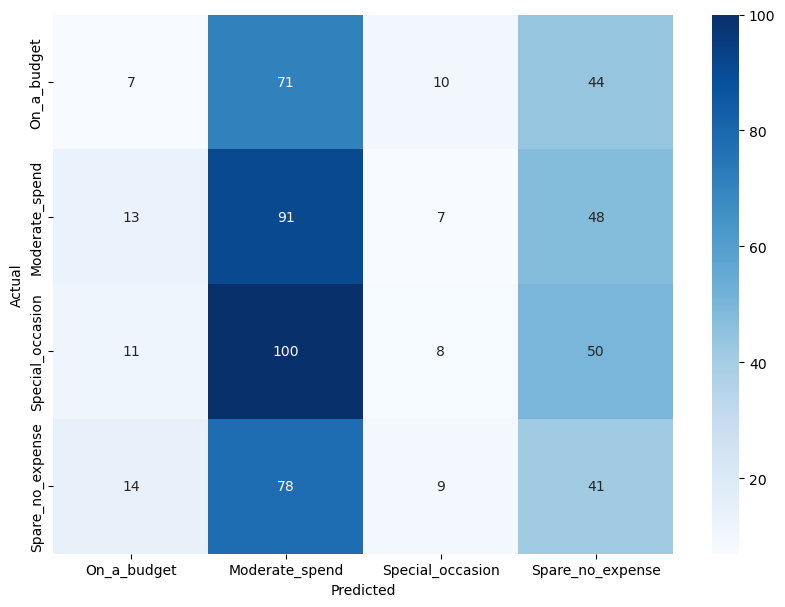

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels
true_labels = valid_batch.classes

# Predict labels of test data
predictions = model.predict(valid_batch)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
confusion_matrix = confusion_matrix(true_labels, predicted_labels)
print(confusion_matrix)


# Define the labels of the classes
classes=['On_a_budget', 'Moderate_spend', 'Special_occasion', 'Spare_no_expense']

# Create a dataframe from the confusion matrix
df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)

# Create the heatmap using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## visualizing 

(1, 299, 299, 3)


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_2364\3753714250.py:46: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(display_grid, aspect='auto', cmap='viridis')


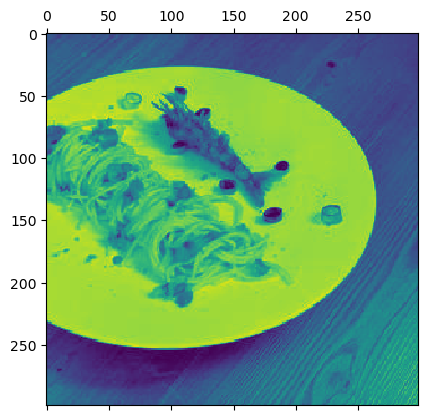

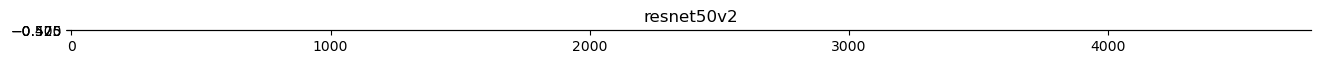

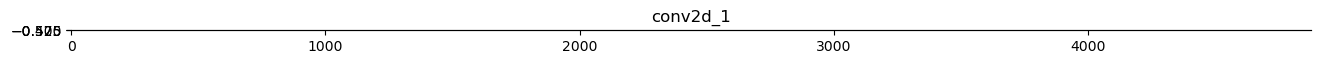

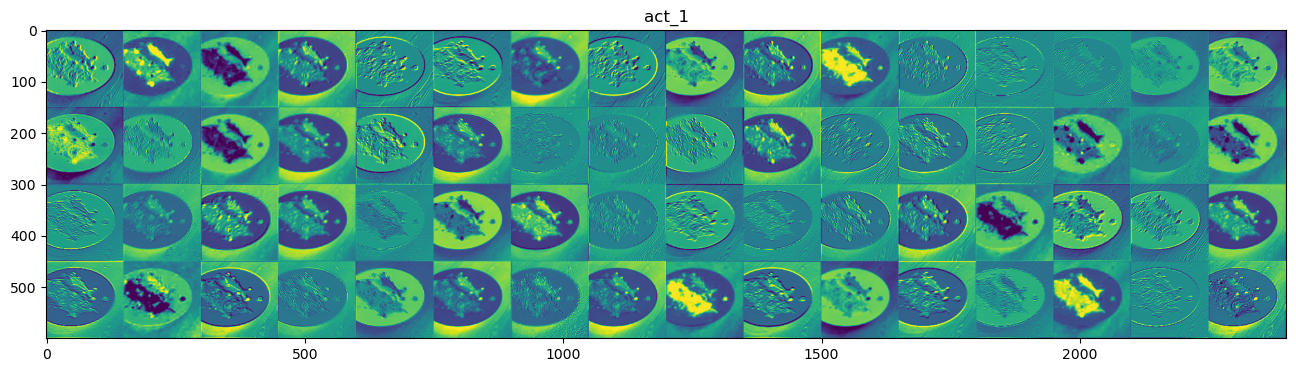

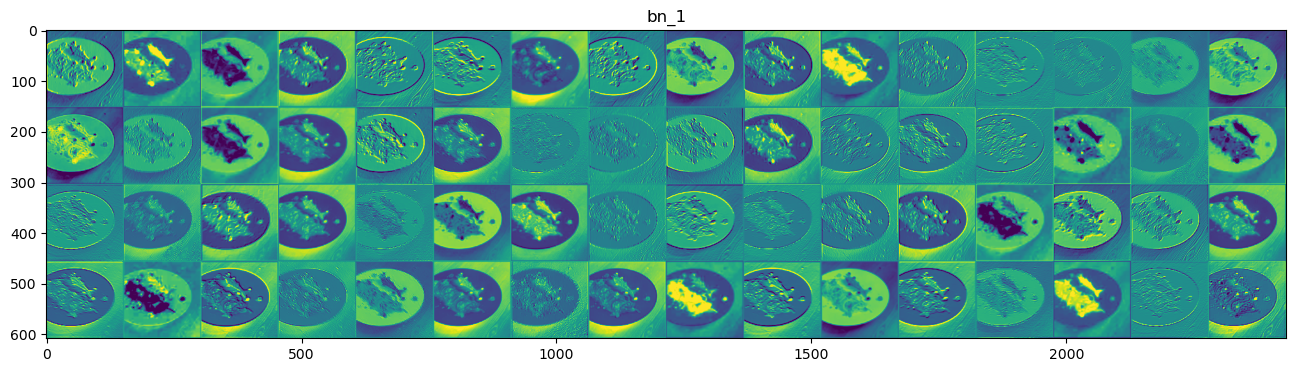

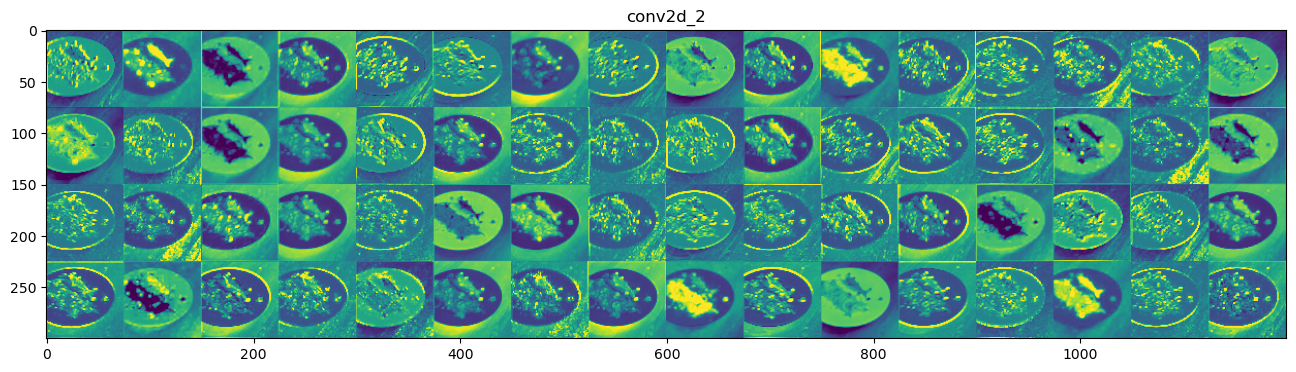

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# Load the image
img_path = r"C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train_2\Special_occasion\Special occasion_214077.jpg"
img = image.load_img(img_path, target_size=(299, 299))

# Convert it to a Numpy array with target shape and preprocess it
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

layer_outputs = [layer.output for layer in base_model.layers[:5]]  # Extracts the outputs of the top 5 layers
activation_model = tf.keras.models.Model(inputs=base_model.input, outputs=layer_outputs)  
activations = activation_model.predict(img_tensor)  # Returns a list of five Numpy arrays: one array per layer activation
first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis') # 4 is the index of filter you want to visualize
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


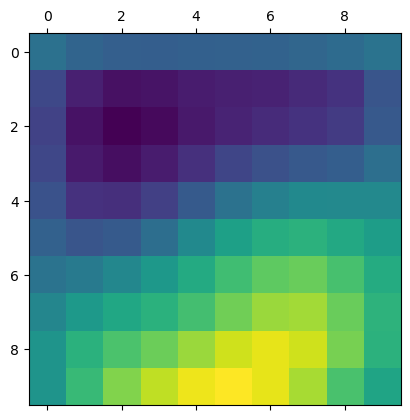

In [27]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import tensorflow as tf

# Choose a layer to visualize
layer_name = 'conv2d_5' # adjust this to the name of a layer in your model
intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Define image size
img_size = (299, 299)  # adjust this to the input size your model expects

# Load the image with the correct size
img = load_img(r"C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train_2\Special_occasion\Special occasion_214077.jpg", target_size=img_size)

# Convert the image to a numpy array
img_array = img_to_array(img)

# Add an extra dimension for the batch
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_array = preprocess_input(img_array)

# Now use the preprocessed image to generate activations
activations = intermediate_layer_model.predict(img_array)

# Display the activations
plt.matshow(activations[0, :, :, 0], cmap='viridis')



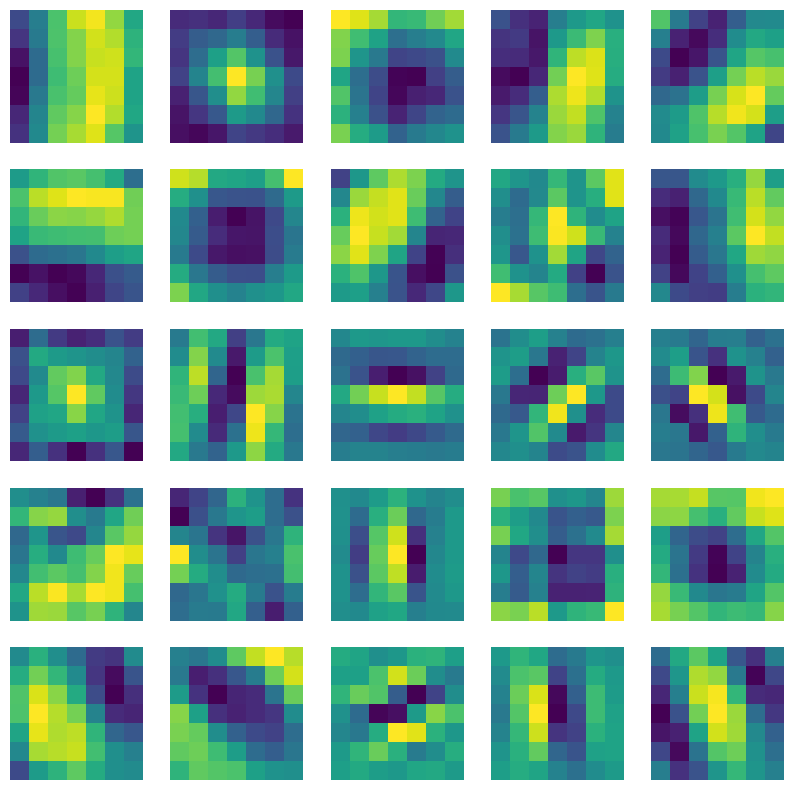

In [8]:
# Get the weights of the first layer
weights = model.layers[0].get_weights()[0]

# Normalize the weights for visualization
weights = (weights - weights.min()) / (weights.max() - weights.min())

# Plot the weights
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(weights[:, :, 0, i], cmap='viridis')
    plt.axis('off')


## Binary system


In [12]:
#Set up values
epochs = 30
input_shape=(299,299,3)
batch_size=32
classes=['Special_occasion', 'Spare_no_expense']
l1_reg = 0.001
l2_reg = 0.001


train_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train_2'
test_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\test_2'
valid_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\valid_2'

# Create the data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input, 
                                   #rotation_range=30, 
                                   #width_shift_range=0.2, 
                                   #height_shift_range=0.2, 
                                   #shear_range=0.2, 
                                   #zoom_range=0.2, 
                                   #horizontal_flip=True, 
                                   #fill_mode='nearest'
                                   )
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input, 
                                  #rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
                                   )

train_batch = train_datagen.flow_from_directory(train_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb',
subset='training',
classes=classes,
shuffle=True)

test_batch = test_datagen.flow_from_directory(test_path,
target_size=(299, 299),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb',
subset='training',
classes=classes,
shuffle=False)

valid_batch = test_datagen.flow_from_directory(valid_path,
target_size=(299, 299),
batch_size=batch_size,
color_mode='rgb',
class_mode='categorical',
classes=classes)


# Import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras import regularizers

# Drops learning rate by half if the accuracy does not improve after 2 epochs (patience=2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)

# Setting class weights
class_indices = train_batch.class_indices
num_classes = len(class_indices)
total_samples = train_batch.samples

class_samples = [train_batch.classes.tolist().count(i) for i in range(num_classes)]
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_batch.classes), y=train_batch.classes)
class_weight_dict = {i : class_weights[i] for i in range(num_classes)}


# Create the base model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the earlier layers of ResNet50V2
for layer in base_model.layers[:-500]:
    layer.trainable = False

# Fine-tune the last two blocks of ResNet50V2
for layer in base_model.layers[-500:]:
    layer.trainable = True

# Create the model
model = Sequential()
model.add(base_model)

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))

model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Activation('relu'))

model.add(Dense(2))
model.add(Activation('sigmoid'))

optimizer = Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(train_batch, epochs=epochs, validation_data=test_batch, class_weight=class_weight_dict, 
          callbacks=[reduce_lr, tensorboard_callback], steps_per_epoch=len(train_batch), validation_steps=len(test_batch))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(valid_batch)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Found 10038 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 311 images belonging to 2 classes.


c:\Users\Gebruiker\anaconda3\envs\tf_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/30
314/314 [==============================] - 117s 352ms/step - loss: 120.5362 - accuracy: 0.5237 - val_loss: 113.4537 - val_accuracy: 0.5290
Epoch 2/30
314/314 [==============================] - 92s 293ms/step - loss: 106.7129 - accuracy: 0.5746 - val_loss: 100.0995 - val_accuracy: 0.5610
Epoch 3/30
314/314 [==============================] - 99s 314ms/step - loss: 93.8053 - accuracy: 0.6495 - val_loss: 87.7189 - val_accuracy: 0.5490
Epoch 4/30
314/314 [==============================] - 94s 298ms/step - loss: 81.6821 - accuracy: 0.8265 - val_loss: 76.5949 - val_accuracy: 0.5155
Epoch 5/30
314/314 [==============================] - 92s 292ms/step - loss: 73.0496 - accuracy: 0.9602 - val_loss: 71.3403 - val_accuracy: 0.5405
Epoch 6/30
 48/314 [===>..........................] - ETA: 1:15 - loss: 69.9097 - accuracy: 0.9823

KeyboardInterrupt: 